In [ ]:
"""
Step 2: Build ACS dataset for analysis
--------------------------------------
This script is broken into 3 parts: 
1. Collapses the poverty table into a simplified version(this dataset is sooo detailed hol)
2. Joins poverty, median income, and total population
3. Adds census equivalency mapping (tract -> borough/NTA/CDTA)
"""

In [22]:
import sqlite3
import pandas as pd
# Connect to my sqlite database
db_path = "/Users/ayemaq/Desktop/Datathon/mta_equity.db"   
conn = sqlite3.connect(db_path)
cur = conn.cursor()

In [2]:
# step 1: collpase poverty table
#poverty = pd.read_csv("poverty.csv", skiprows=0)  # adjust skiprows if needed

collapse_poverty = """
CREATE TABLE IF NOT EXISTS poverty_simple AS
SELECT 
    GEO_ID,
    NAME,
    B17021_001E AS total_for_poverty,
    -- Sum of people in poverty (bins 002–017)
    (B17021_002E + B17021_003E + B17021_004E + B17021_005E +
     B17021_006E + B17021_007E + B17021_008E + B17021_009E +
     B17021_010E + B17021_011E + B17021_012E + B17021_013E +
     B17021_014E + B17021_015E + B17021_016E + B17021_017E) AS in_poverty,
    -- Sum of people not in poverty (bins 018–035)
    (B17021_018E + B17021_019E + B17021_020E + B17021_021E +
     B17021_022E + B17021_023E + B17021_024E + B17021_025E +
     B17021_026E + B17021_027E + B17021_028E + B17021_029E +
     B17021_030E + B17021_031E + B17021_032E + B17021_033E +
     B17021_034E + B17021_035E) AS not_in_poverty,
    -- Poverty rate
    (CAST(
        (B17021_002E + B17021_003E + B17021_004E + B17021_005E +
         B17021_006E + B17021_007E + B17021_008E + B17021_009E +
         B17021_010E + B17021_011E + B17021_012E + B17021_013E +
         B17021_014E + B17021_015E + B17021_016E + B17021_017E) AS FLOAT
     ) / NULLIF(B17021_001E,0)) AS poverty_rate
FROM poverty;
"""
cur.execute("DROP TABLE IF EXISTS poverty_simple;")  # refresh if re-running
cur.execute(collapse_poverty)


In [ ]:
# step 2: join poverty, median income, and population
join_acs = """
CREATE TABLE IF NOT EXISTS acs_joined AS
SELECT 
    m.GEO_ID,
    m.NAME,
    m.B19013_001E AS median_income,
    pop.B01003_001E AS total_population,
    ps.in_poverty,
    ps.not_in_poverty,
    ps.poverty_rate
FROM median_income m
JOIN poverty_simple ps
    ON m.GEO_ID = ps.GEO_ID
JOIN population pop 
    ON m.GEO_ID = pop.GEO_ID;
"""
cur.execute("DROP TABLE IF EXISTS acs_joined;")
cur.execute(join_acs)


##### Sanity checks for step 2
- The follow blocks are to double check my queries

In [ ]:
# sanity check
df = pd.read_sql_query("SELECT * FROM acs_joined LIMIT 5;", conn)
df

,GEO_ID,NAME,median_income,total_population,in_poverty,not_in_poverty,poverty_rate
0,Geography,Geographic Area Name,Estimate!!Median household income in the past ...,Estimate!!Total,0,0,NaN
1,1400000US36005000100,Census Tract 1; Bronx County; New York,-,3538,0,0,NaN
2,1400000US36005000200,Census Tract 2; Bronx County; New York,121171,5177,3301,19274,0.637628
3,1400000US36005000400,Census Tract 4; Bronx County; New York,98242,6481,1391,27016,0.214627
4,1400000US36005001600,Census Tract 16; Bronx County; New York,42957,6011,4219,21256,0.732592


In [9]:
print(df.shape)  # how many rows & columns
print(df.isna().sum())  # how many missing values per column


(5, 7)
GEO_ID              0
NAME                0
median_income       0
total_population    0
in_poverty          0
not_in_poverty      0
poverty_rate        2
dtype: int64


In [10]:
df = df[df["GEO_ID"] != "Geography"]


In [11]:
print(df.shape)  # how many rows & columns
print(df.isna().sum())  # how many missing values per column


(4, 7)
GEO_ID              0
NAME                0
median_income       0
total_population    0
in_poverty          0
not_in_poverty      0
poverty_rate        1
dtype: int64


In [12]:
total_rows = pd.read_sql_query("SELECT COUNT(*) as n FROM acs_joined;", conn)
print(total_rows)


      n
0  2018


<Axes: >

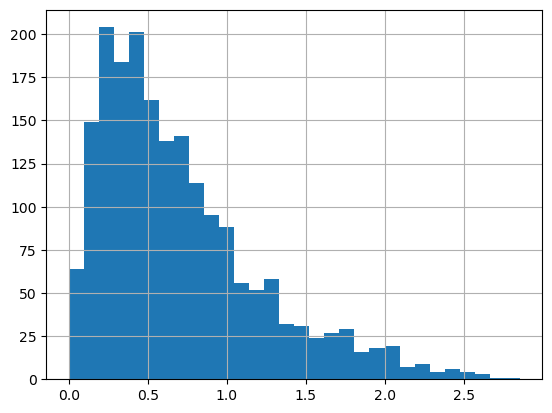

In [14]:
df = pd.read_sql_query("SELECT * FROM acs_joined;", conn)
df["poverty_rate"].hist(bins=30)


##### Step 3: Add census equivalency mapping (tract → borough/NTA/CDTA)

In [19]:
add_mapping = """
CREATE TABLE IF NOT EXISTS acs_with_mapping AS
SELECT 
    a.*,
    ce.BOROCODE,
    ce.BORONAME,
    ce.NTACODE,
    ce.NTANAME,
    ce.CDTACODE,
    ce.CDTANAME
FROM acs_joined a
JOIN census_equivalency ce
    ON a.GEO_ID = ce.GEOID;
"""
cur.execute("DROP TABLE IF EXISTS acs_with_mapping;")
cur.execute(add_mapping)

conn.commit()


In [ ]:
df = pd.read_sql_query("SELECT * FROM acs_with_mapping LIMIT 10;", conn)
print(df)

#conn.close()


Empty DataFrame
Columns: [GEO_ID, NAME, median_income, total_population, in_poverty, not_in_poverty, poverty_rate, BOROCODE, BORONAME, NTACODE, NTANAME, CDTACODE, CDTANAME]
Index: []


SO.... no rows huh....

because: 

acs_joined has prefix "1400000US" before the census tract code (GEO_ID = 1400000US36005000100)
census_equivalency has GEOID = 36005001901


In [23]:
print(pd.read_sql_query("SELECT GEO_ID FROM acs_joined LIMIT 5;", conn))
print(pd.read_sql_query("SELECT GEOID FROM census_equivalency LIMIT 5;", conn))


                 GEO_ID
0             Geography
1  1400000US36005000100
2  1400000US36005000200
3  1400000US36005000400
4  1400000US36005001600
         GEOID
0  36005001901
1  36005001902
2  36005001903
3  36005002300
4  36005002500


In [29]:
add_mapping = """
CREATE TABLE IF NOT EXISTS acs_with_mapping AS
SELECT
    a.*,
    ce.BOROCODE,
    ce.BORONAME,
    ce.NTACODE,
    ce.NTANAME,
    ce.CT2020,
    ce.CTLABEL,
    ce.CDTACODE,
    ce.CDTANAME
FROM acs_joined a
JOIN census_equivalency ce
    -- strip '1400000US' prefix so GEO_ID matches GEOID
    ON substr(a.GEO_ID, 10) = ce.GEOID;
"""

cur.execute("DROP TABLE IF EXISTS acs_with_mapping;")  # refresh if re-running
cur.execute(add_mapping)
conn.commit()

# Sanity check: preview results
df = pd.read_sql_query("SELECT * FROM acs_with_mapping LIMIT 5;", conn)
df


,GEO_ID,NAME,median_income,total_population,in_poverty,not_in_poverty,poverty_rate,BOROCODE,BORONAME,NTACODE,NTANAME,CT2020,CTLABEL,CDTACODE,CDTANAME
0,1400000US36005000100,Census Tract 1; Bronx County; New York,-,3538,0,0,NaN,2,Bronx,QN0151,Rikers Island,100,1.00,QN01,QN01 Astoria-Queensbridge (CD 1 Equivalent)
1,1400000US36005000200,Census Tract 2; Bronx County; New York,121171,5177,3301,19274,0.637628,2,Bronx,BX0902,Soundview-Clason Point,200,2.00,BX09,BX09 Soundview-Parkchester (CD 9 Approximation)
2,1400000US36005000400,Census Tract 4; Bronx County; New York,98242,6481,1391,27016,0.214627,2,Bronx,BX0902,Soundview-Clason Point,400,4.00,BX09,BX09 Soundview-Parkchester (CD 9 Approximation)
3,1400000US36005001600,Census Tract 16; Bronx County; New York,42957,6011,4219,21256,0.732592,2,Bronx,BX0902,Soundview-Clason Point,1600,16.00,BX09,BX09 Soundview-Parkchester (CD 9 Approximation)
4,1400000US36005001901,Census Tract 19.01; Bronx County; New York,67361,2401,3310,7261,1.381469,2,Bronx,BX0101,Mott Haven-Port Morris,1901,19.01,BX01,BX01 Melrose-Mott Haven-Port Morris (CD 1 Appr...


In [30]:
df = df[df["GEO_ID"] != "Geography"]
df = pd.read_sql_query("SELECT * FROM acs_with_mapping LIMIT 5;", conn)
print(df)


                 GEO_ID                                        NAME  \
0  1400000US36005000100      Census Tract 1; Bronx County; New York   
1  1400000US36005000200      Census Tract 2; Bronx County; New York   
2  1400000US36005000400      Census Tract 4; Bronx County; New York   
3  1400000US36005001600     Census Tract 16; Bronx County; New York   
4  1400000US36005001901  Census Tract 19.01; Bronx County; New York   

  median_income total_population  in_poverty  not_in_poverty  poverty_rate  \
0             -             3538           0               0           NaN   
1        121171             5177        3301           19274      0.637628   
2         98242             6481        1391           27016      0.214627   
3         42957             6011        4219           21256      0.732592   
4         67361             2401        3310            7261      1.381469   

   BOROCODE BORONAME NTACODE                 NTANAME  CT2020  CTLABEL  \
0         2    Bronx  QN0151   

#### Now lets answer the question:
- Map low-income and transit-dependent areas, and compare their bus performance and enforcement coverage.”
- Basically I am answering this 2 ways: 
    1. Which neighborhoods (NTAs) are low-income (high poverty)?
    2. Do those neighborhoods have ACE enforcement (bus routes with cameras)?
- So my analysis = poverty rate by neighborhood vs ACE route coverage.

In [33]:
pd.read_sql_query("PRAGMA table_info(ace_routes);", conn)


,cid,name,type,notnull,dflt_value,pk
0,0,ROUTE,TEXT,0,None,0
1,1,PROGRAM,TEXT,0,None,0
2,2,IMPLEMENTATION_DATE,TEXT,0,None,0


In [35]:
# Step A (part 1): Poverty by NTA (without ACE yet)

nta_poverty = """
CREATE TABLE IF NOT EXISTS nta_poverty AS
SELECT
    a.BORONAME,
    a.NTACODE,
    a.NTANAME,
    ROUND(AVG(a.poverty_rate), 3) AS avg_poverty_rate,
    ROUND(AVG(a.median_income), 0) AS avg_median_income,
    SUM(a.total_population) AS total_population
FROM acs_with_mapping a
GROUP BY a.BORONAME, a.NTACODE, a.NTANAME
ORDER BY avg_poverty_rate DESC;
"""

cur.execute("DROP TABLE IF EXISTS nta_poverty;")  # refresh if re-running
cur.execute(nta_poverty)

# Sanity check: preview first few rows
df = pd.read_sql_query("SELECT * FROM nta_poverty LIMIT 10;", conn)
print(df)


   BORONAME NTACODE                             NTANAME  avg_poverty_rate  \
0     Bronx  BX0601                          West Farms             1.965   
1    Queens  QN0161             Sunnyside Yards (North)             1.805   
2     Bronx  BX0603                             Belmont             1.785   
3     Bronx  BX0101              Mott Haven-Port Morris             1.747   
4  Brooklyn  BK0103                  South Williamsburg             1.738   
5     Bronx  BX0302  Claremont Village-Claremont (East)             1.709   
6     Bronx  BX0102                             Melrose             1.651   
7     Bronx  BX0301                          Morrisania             1.633   
8     Bronx  BX0602                             Tremont             1.574   
9     Bronx  BX0503                     Fordham Heights             1.509   

   avg_median_income  total_population  
0            32027.0             17898  
1                0.0                44  
2            31272.0         

In [36]:
df = pd.read_sql_query("SELECT * FROM nta_poverty;", conn)
df.to_csv("nta_poverty.csv", index=False)
